# Error study

In this file I study the error of the algorithm. Since there is a big error coming from the thermalization it makes no sense to be extremely precise in the subsequent TEBD. What I require is to have the maximum error to be less than 0.1% and get the right values for the tolerance and cutoff.

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import time

import quimb as qu
import quimb.tensor as qtn
import quimb.linalg.base_linalg as la
from itertools import product

In [8]:
### PROBLEM PARAMETERS
L = 7         # chain length
omega = 1     # Rabi frequency
V = 0.5       # B-S interaction strength
V_ = 0.5      # bath interaction strength
beta = 0.05   # inverse temperature for the bath

T = 10        # total time of the simulation
dt = 0.1      # time step for coherece vector time evolution

#tolerance = 1e-3 # Trotter
#cutoff = 1e-6 # cutoff for TEBD algorithm

### USEFULL VARIABLES
dims = [2]*L # overall space of L qbits

I = qu.pauli('I')
X = qu.pauli('Y')
Z = qu.pauli('Z')

In [9]:
def calculate_error(L, omega, V, V_, beta, T, dt, re_cutoff, img_cutoff, tolerance):
    ### BUILDING THE HAMILTONIAN

    # fisrt I build the operators
    nn_op = (I + Z)/2 & (I + Z)/2

    print(f'Building Hamiltonian for L={L}')
    # the hamiltonian
    H_Rabi = sum(qu.ikron(X, dims, i) for i in range(L))
    H_int_b = sum(qu.ikron(nn_op, dims, (i, i+1)) for i in range(2, L-1))
    H_int_s = sum(qu.pkron(nn_op, dims, (i, j)) for i,j in zip([L-1,0,1], [0,1,2]))

    H = (omega/2)*H_Rabi + V_*H_int_b + V*H_int_s

    # diagonalization
    e, U = la.eig(H, isherm=True)

    #print('done :)')
    
    ### BUILDING THE OBSERVABLES

    observables_ex = {}
    results_ex = {}
    for ob1, ob2 in product(['I', 'X', 'Y', 'Z'], repeat=2):
        key = ob1 + '1' + ob2 + '2'
        results_ex[key] = []
        observables_ex[key] = qu.ikron(qu.pauli(ob1)&qu.pauli(ob2), dims, (0, 1))

    # dropping the identity
    observables_ex.pop('I1I2')
    results_ex.pop('I1I2')


    ### INITIAL CONDITIONS
    print('Initial state: random subsystem and thermal bath\n')

    #rho = la.expm(-beta*H)
    #rho /= rho.trace()

    rho = qu.gen.states.thermal_state(H, beta)

    # apply a random operator to the first two spins
    rand1 = qu.gen.rand.rand_uni(2)
    rand2 = qu.gen.rand.rand_uni(2)
    U_rand = qu.ikron(rand1 & rand2, dims, (0, 1))
    rho = U_rand @ rho @ U_rand.H

    ### THE SIMULATION

    # smarter way to calculate the coherence vector:
    rho_tilde = np.conj(U.T) @ rho @ U    

    pauli_tilde = {}
    t = []
    for key in observables_ex.keys():
        pauli_tilde[key] = np.conj(U.T) @ observables_ex[key] @ U

    for i in range(0, int(T/dt)):
        ee = np.exp(-1j*e*dt*i)  # diagonalized hamiltonian
        rho_in = ee.reshape(ee.shape[0],1)*rho_tilde*np.conj(ee)

        trace = lambda key: ( (pauli_tilde[key]@rho_in).trace() / rho_tilde.trace()).real
        for key in results_ex.keys():
            results_ex[key].append(trace(key))

        t.append( dt*i )

    #print("finished Time = %s" % T)

    print('done')
    
    
    ### BUILDING THE HAMILTONIAN for the thermalization

    O_Rabi = (omega/2)*X & I
    N = (I + Z)/2 & I

    print(f'Building Hamiltonian for L={L} \n')
    # the hamiltonian
    H1 = {i: O_Rabi for i in range(L)}
    H2 = {None: V_*N&N, (L-1, 0): V*N&N, (0, 1): V*N&N, (1, 2): V*N&N}

    H = qtn.LocalHam1D(L=L, H2=H2, H1=H1, cyclic=True)

    ### BUILDING THE SPIN CHAIN

    print('Building the spin chain \n')
    B = np.array([1, 0, 0, 1])/np.sqrt(2)
    arrays = [B for i in range(L)]

    psi = qtn.MPS_product_state(arrays, cyclic=True)#, site_ind_id='s{}')

    #psi.show()
    
    ### IMAGINARY TIME EVOLUTION

    print('Imaginary time evolution \n')

    # create the object
    tebd_th = qtn.TEBD(psi, H, imag=True)

    # cutoff for truncating after each infinitesimal-time operator application
    tebd_th.split_opts['cutoff'] = img_cutoff

    tebd_th.update_to(beta/2, tol=tolerance)
    psi_th = tebd_th.pt
    
    ### INITIAL CONDITIONS

    # random initial conditions
    Rand1 = rand1 & qu.pauli('I')
    Rand2 = rand2 & qu.pauli('I')

    psi_init = psi_th.gate(Rand1&Rand2, (0,1), contract='swap+split')

    ### THE SIMULATION
    
    print('Real time evolution')
    start = time.time()

    # first I build the observables
    observables_tebd = {}
    results_tebd = {}
    for ob1, ob2 in product(['I', 'X', 'Y', 'Z'], repeat=2):
        key = ob1 + '1' + ob2 + '2'
        results_tebd[key] = []
        observables_tebd[key] = []

    # dropping the identity
    observables_tebd.pop('I1I2')
    results_tebd.pop('I1I2')

    # create the object
    tebd = qtn.TEBD(psi_init, H)

    # cutoff for truncating after each infinitesimal-time operator application
    tebd.split_opts['cutoff'] = re_cutoff

    keys = results_tebd.keys()

    # I can either set a timestep or a tolerance and the timestep is calculated accordingly
    # generate the state at each time in t (same as exact simulation)
    #     and target error 1e-3 for whole evolution
    for psit in tebd.at_times(t, tol=tolerance):
        for key in keys:
            ob1 = qu.pauli(key[0]) & qu.pauli('I')
            ob2 = qu.pauli(key[2]) & qu.pauli('I')
            results_tebd[key].append((psit.H @ psit.gate(ob1 & ob2, (0, 1))).real)

    end = time.time()
    print(f'Time:{int(end - start)}s')
    
    ### GET ERROR
    # I am interested in the maximum error
    keys = observables_tebd.keys()

    diff = {}
    max_err = 0

    for key in keys:
        diff[key] = np.array([results_ex[key][i] - results_tebd[key][i] for i in range(len(t))])
        tmp = np.abs(diff[key]).max()
        if tmp > max_err:
            max_err = tmp
    print(f'Max error {max_err}')
    
    ### PLOT
    # here I plot the difference in the expectation values
    plt.figure(dpi=130)#figsize=(9, 6))

    for key in keys:
        plt.plot(t, diff[key], linewidth=0.5, label=key)

    # plot also the norm of the difference of the vectors
    norm = []
    for i in range(len(t)):
        x = []
        for key in diff.keys():
            x.append(diff[key][i])
        norm.append(np.linalg.norm(x))
    plt.plot(t, norm, linewidth=1.5, linestyle='dashed', color='black')

    plt.grid()
    plt.xlabel(r't/$\Omega$')
    plt.title('Exact - TEBD')

    fig = plt.gcf()
    #plt.legend()
    plt.show()
    
    return max_err

In [4]:
table = np.empty([7,7])

for i in range(7):
    for j in range(7):
        print(f'i = {i}, j = {j} =====================================')
        avrg = 0
        for k in range(5):
            print(f'Simulation {(i*7 + j)*5 + k} / {7*7*5}')
            avrg += calculate_error(L, omega, V, V_, beta, T, dt, 10**(-2-i), 10**(-2-j), tolerance)
        table[i][j] = avrg/5


i = 0, j = 0 =====================================
Simulation 0 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 4330.45%/s]


Real time evolution


t=9.9, max-bond=4: 100%|####################################################################################################################################################################################################| 100/100 [00:02<00:00, 40.17it/s]


Time:2s
Max error 0.0076930970433711785
Simulation 1 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7146.78%/s]


Real time evolution


t=9.9, max-bond=4: 100%|####################################################################################################################################################################################################| 100/100 [00:02<00:00, 39.93it/s]


Time:2s
Max error 0.006393686371693479
Simulation 2 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7453.10%/s]


Real time evolution


t=9.9, max-bond=4: 100%|####################################################################################################################################################################################################| 100/100 [00:02<00:00, 39.94it/s]


Time:2s
Max error 0.004471732405328925
Simulation 3 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7310.33%/s]


Real time evolution


t=9.9, max-bond=4: 100%|####################################################################################################################################################################################################| 100/100 [00:02<00:00, 39.95it/s]


Time:2s
Max error 0.007336595187025116
Simulation 4 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7254.32%/s]


Real time evolution


t=9.9, max-bond=4: 100%|####################################################################################################################################################################################################| 100/100 [00:02<00:00, 40.01it/s]


Time:2s
Max error 0.008217034749329319
i = 0, j = 1 =====================================
Simulation 5 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7245.93%/s]


Real time evolution


t=9.9, max-bond=4: 100%|####################################################################################################################################################################################################| 100/100 [00:02<00:00, 39.76it/s]


Time:2s
Max error 0.004566686393719962
Simulation 6 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7363.21%/s]


Real time evolution


t=9.9, max-bond=4: 100%|####################################################################################################################################################################################################| 100/100 [00:02<00:00, 40.05it/s]


Time:2s
Max error 0.006626293129421493
Simulation 7 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7276.60%/s]


Real time evolution


t=9.9, max-bond=4: 100%|####################################################################################################################################################################################################| 100/100 [00:02<00:00, 39.73it/s]


Time:2s
Max error 0.005848847470507385
Simulation 8 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7365.28%/s]


Real time evolution


t=9.9, max-bond=4: 100%|####################################################################################################################################################################################################| 100/100 [00:02<00:00, 40.01it/s]


Time:2s
Max error 0.004848874552634391
Simulation 9 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7349.02%/s]


Real time evolution


t=9.9, max-bond=4: 100%|####################################################################################################################################################################################################| 100/100 [00:02<00:00, 39.75it/s]


Time:2s
Max error 0.005730504917763163
i = 0, j = 2 =====================================
Simulation 10 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6802.20%/s]


Real time evolution


t=9.9, max-bond=4: 100%|####################################################################################################################################################################################################| 100/100 [00:02<00:00, 39.59it/s]


Time:2s
Max error 0.005025929039807798
Simulation 11 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7122.15%/s]


Real time evolution


t=9.9, max-bond=4: 100%|####################################################################################################################################################################################################| 100/100 [00:02<00:00, 38.71it/s]


Time:2s
Max error 0.0044777827557392616
Simulation 12 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7058.62%/s]


Real time evolution


t=9.9, max-bond=4: 100%|####################################################################################################################################################################################################| 100/100 [00:02<00:00, 40.00it/s]


Time:2s
Max error 0.003516850371303388
Simulation 13 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7016.12%/s]


Real time evolution


t=9.9, max-bond=4: 100%|####################################################################################################################################################################################################| 100/100 [00:02<00:00, 39.73it/s]


Time:2s
Max error 0.0031842934518601265
Simulation 14 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7080.55%/s]


Real time evolution


t=9.9, max-bond=4: 100%|####################################################################################################################################################################################################| 100/100 [00:02<00:00, 39.95it/s]


Time:2s
Max error 0.004652087445865274
i = 0, j = 3 =====================================
Simulation 15 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6890.03%/s]


Real time evolution


t=9.9, max-bond=4: 100%|####################################################################################################################################################################################################| 100/100 [00:02<00:00, 39.99it/s]


Time:2s
Max error 0.00473371238906847
Simulation 16 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7025.75%/s]


Real time evolution


t=9.9, max-bond=4: 100%|####################################################################################################################################################################################################| 100/100 [00:02<00:00, 39.93it/s]


Time:2s
Max error 0.004229131398974034
Simulation 17 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7035.77%/s]


Real time evolution


t=9.9, max-bond=4: 100%|####################################################################################################################################################################################################| 100/100 [00:02<00:00, 39.93it/s]


Time:2s
Max error 0.003693316166211813
Simulation 18 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6818.79%/s]


Real time evolution


t=9.9, max-bond=4: 100%|####################################################################################################################################################################################################| 100/100 [00:02<00:00, 39.85it/s]


Time:2s
Max error 0.0034887202878640658
Simulation 19 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6954.81%/s]


Real time evolution


t=9.9, max-bond=4: 100%|####################################################################################################################################################################################################| 100/100 [00:02<00:00, 39.82it/s]


Time:2s
Max error 0.00482833916474234
i = 0, j = 4 =====================================
Simulation 20 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7015.65%/s]


Real time evolution


t=9.9, max-bond=4: 100%|####################################################################################################################################################################################################| 100/100 [00:02<00:00, 39.65it/s]


Time:2s
Max error 0.005139837609748262
Simulation 21 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6610.20%/s]


Real time evolution


t=9.9, max-bond=4: 100%|####################################################################################################################################################################################################| 100/100 [00:02<00:00, 39.07it/s]


Time:2s
Max error 0.005253295213025501
Simulation 22 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6892.86%/s]


Real time evolution


t=9.9, max-bond=4: 100%|####################################################################################################################################################################################################| 100/100 [00:02<00:00, 40.02it/s]


Time:2s
Max error 0.0026800077654638857
Simulation 23 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6892.40%/s]


Real time evolution


t=9.9, max-bond=4: 100%|####################################################################################################################################################################################################| 100/100 [00:02<00:00, 40.15it/s]


Time:2s
Max error 0.0039477969024600615
Simulation 24 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6854.11%/s]


Real time evolution


t=9.9, max-bond=4: 100%|####################################################################################################################################################################################################| 100/100 [00:02<00:00, 39.96it/s]


Time:2s
Max error 0.003528284605145821
i = 0, j = 5 =====================================
Simulation 25 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6776.37%/s]


Real time evolution


t=9.9, max-bond=4: 100%|####################################################################################################################################################################################################| 100/100 [00:02<00:00, 37.92it/s]


Time:2s
Max error 0.004978091604808943
Simulation 26 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6627.96%/s]


Real time evolution


t=9.9, max-bond=4: 100%|####################################################################################################################################################################################################| 100/100 [00:02<00:00, 36.00it/s]


Time:2s
Max error 0.004963772433082242
Simulation 27 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6037.23%/s]


Real time evolution


t=9.9, max-bond=4: 100%|####################################################################################################################################################################################################| 100/100 [00:02<00:00, 35.32it/s]


Time:2s
Max error 0.004353449933382195
Simulation 28 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6093.18%/s]


Real time evolution


t=9.9, max-bond=4: 100%|####################################################################################################################################################################################################| 100/100 [00:02<00:00, 33.95it/s]


Time:2s
Max error 0.005149316579562841
Simulation 29 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 5299.52%/s]


Real time evolution


t=9.9, max-bond=4: 100%|####################################################################################################################################################################################################| 100/100 [00:02<00:00, 33.58it/s]


Time:2s
Max error 0.003281709948403191
i = 0, j = 6 =====================================
Simulation 30 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6529.83%/s]


Real time evolution


t=9.9, max-bond=4: 100%|####################################################################################################################################################################################################| 100/100 [00:02<00:00, 35.26it/s]


Time:2s
Max error 0.0032656870326318336
Simulation 31 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 5179.69%/s]


Real time evolution


t=9.9, max-bond=4: 100%|####################################################################################################################################################################################################| 100/100 [00:02<00:00, 34.16it/s]


Time:2s
Max error 0.0030306757903039725
Simulation 32 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 5965.87%/s]


Real time evolution


t=9.9, max-bond=4: 100%|####################################################################################################################################################################################################| 100/100 [00:02<00:00, 35.93it/s]


Time:2s
Max error 0.005276242003554454
Simulation 33 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 5102.06%/s]


Real time evolution


t=9.9, max-bond=4: 100%|####################################################################################################################################################################################################| 100/100 [00:02<00:00, 35.83it/s]


Time:2s
Max error 0.0035737916602537265
Simulation 34 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6468.60%/s]


Real time evolution


t=9.9, max-bond=4: 100%|####################################################################################################################################################################################################| 100/100 [00:02<00:00, 35.33it/s]


Time:2s
Max error 0.004261214071189019
i = 1, j = 0 =====================================
Simulation 35 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6488.21%/s]


Real time evolution


t=9.9, max-bond=6: 100%|####################################################################################################################################################################################################| 100/100 [00:03<00:00, 29.42it/s]


Time:3s
Max error 0.05004548570451356
Simulation 36 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6789.65%/s]


Real time evolution


t=9.9, max-bond=6: 100%|####################################################################################################################################################################################################| 100/100 [00:03<00:00, 30.17it/s]


Time:3s
Max error 0.05063343321244515
Simulation 37 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6199.36%/s]


Real time evolution


t=9.9, max-bond=6: 100%|####################################################################################################################################################################################################| 100/100 [00:03<00:00, 29.93it/s]


Time:3s
Max error 0.05022780665541231
Simulation 38 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6866.90%/s]


Real time evolution


t=9.9, max-bond=6: 100%|####################################################################################################################################################################################################| 100/100 [00:03<00:00, 30.20it/s]


Time:3s
Max error 0.05004418306037912
Simulation 39 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 4835.66%/s]


Real time evolution


t=9.9, max-bond=6: 100%|####################################################################################################################################################################################################| 100/100 [00:03<00:00, 29.16it/s]


Time:3s
Max error 0.05010048754736589
i = 1, j = 1 =====================================
Simulation 40 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6425.69%/s]


Real time evolution


t=9.9, max-bond=6: 100%|####################################################################################################################################################################################################| 100/100 [00:03<00:00, 29.13it/s]


Time:3s
Max error 0.05022771305313581
Simulation 41 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 4555.66%/s]


Real time evolution


t=9.9, max-bond=6: 100%|####################################################################################################################################################################################################| 100/100 [00:03<00:00, 29.64it/s]


Time:3s
Max error 0.05044539308022834
Simulation 42 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7184.12%/s]


Real time evolution


t=9.9, max-bond=6: 100%|####################################################################################################################################################################################################| 100/100 [00:03<00:00, 30.36it/s]


Time:3s
Max error 0.05022756286171315
Simulation 43 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6686.28%/s]


Real time evolution


t=9.9, max-bond=6: 100%|####################################################################################################################################################################################################| 100/100 [00:03<00:00, 29.63it/s]


Time:3s
Max error 0.050171605247650915
Simulation 44 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6919.01%/s]


Real time evolution


t=9.9, max-bond=6: 100%|####################################################################################################################################################################################################| 100/100 [00:03<00:00, 30.12it/s]


Time:3s
Max error 0.050064060649067654
i = 1, j = 2 =====================================
Simulation 45 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6647.29%/s]


Real time evolution


t=9.9, max-bond=6: 100%|####################################################################################################################################################################################################| 100/100 [00:03<00:00, 29.94it/s]


Time:3s
Max error 0.02463358396144181
Simulation 46 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6279.65%/s]


Real time evolution


t=9.9, max-bond=6: 100%|####################################################################################################################################################################################################| 100/100 [00:03<00:00, 30.27it/s]


Time:3s
Max error 0.02496356158259508
Simulation 47 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 5303.00%/s]


Real time evolution


t=9.9, max-bond=6: 100%|####################################################################################################################################################################################################| 100/100 [00:03<00:00, 30.08it/s]


Time:3s
Max error 0.025197370089614108
Simulation 48 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 5917.14%/s]


Real time evolution


t=9.9, max-bond=6: 100%|####################################################################################################################################################################################################| 100/100 [00:03<00:00, 29.90it/s]


Time:3s
Max error 0.02532328872446573
Simulation 49 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 5522.67%/s]


Real time evolution


t=9.9, max-bond=6: 100%|####################################################################################################################################################################################################| 100/100 [00:03<00:00, 29.57it/s]


Time:3s
Max error 0.025737021520563924
i = 1, j = 3 =====================================
Simulation 50 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 5562.59%/s]


Real time evolution


t=9.9, max-bond=6: 100%|####################################################################################################################################################################################################| 100/100 [00:03<00:00, 29.74it/s]


Time:3s
Max error 0.02567904788548273
Simulation 51 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6549.81%/s]


Real time evolution


t=9.9, max-bond=6: 100%|####################################################################################################################################################################################################| 100/100 [00:03<00:00, 29.44it/s]


Time:3s
Max error 0.02561874077413974
Simulation 52 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 5232.94%/s]


Real time evolution


t=9.9, max-bond=6: 100%|####################################################################################################################################################################################################| 100/100 [00:03<00:00, 29.97it/s]


Time:3s
Max error 0.025350404596802104
Simulation 53 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6314.63%/s]


Real time evolution


t=9.9, max-bond=6: 100%|####################################################################################################################################################################################################| 100/100 [00:03<00:00, 30.36it/s]


Time:3s
Max error 0.025027000110050462
Simulation 54 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 4538.41%/s]


Real time evolution


t=9.9, max-bond=6: 100%|####################################################################################################################################################################################################| 100/100 [00:03<00:00, 29.63it/s]


Time:3s
Max error 0.02584097165987516
i = 1, j = 4 =====================================
Simulation 55 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6190.95%/s]


Real time evolution


t=9.9, max-bond=6: 100%|####################################################################################################################################################################################################| 100/100 [00:03<00:00, 30.34it/s]


Time:3s
Max error 0.025331379759019078
Simulation 56 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6804.63%/s]


Real time evolution


t=9.9, max-bond=6: 100%|####################################################################################################################################################################################################| 100/100 [00:03<00:00, 30.40it/s]


Time:3s
Max error 0.025331046697898693
Simulation 57 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6404.40%/s]


Real time evolution


t=9.9, max-bond=6: 100%|####################################################################################################################################################################################################| 100/100 [00:03<00:00, 29.75it/s]


Time:3s
Max error 0.025813130942303766
Simulation 58 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6294.26%/s]


Real time evolution


t=9.9, max-bond=6: 100%|####################################################################################################################################################################################################| 100/100 [00:03<00:00, 29.91it/s]


Time:3s
Max error 0.02524525393482991
Simulation 59 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6752.26%/s]


Real time evolution


t=9.9, max-bond=6: 100%|####################################################################################################################################################################################################| 100/100 [00:03<00:00, 30.65it/s]


Time:3s
Max error 0.02569472998858307
i = 1, j = 5 =====================================
Simulation 60 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 5637.43%/s]


Real time evolution


t=9.9, max-bond=6: 100%|####################################################################################################################################################################################################| 100/100 [00:03<00:00, 29.60it/s]


Time:3s
Max error 0.025880967709866573
Simulation 61 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 4148.83%/s]


Real time evolution


t=9.9, max-bond=6: 100%|####################################################################################################################################################################################################| 100/100 [00:03<00:00, 30.11it/s]


Time:3s
Max error 0.02556530115004985
Simulation 62 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6603.85%/s]


Real time evolution


t=9.9, max-bond=6: 100%|####################################################################################################################################################################################################| 100/100 [00:03<00:00, 30.80it/s]


Time:3s
Max error 0.025334764179017966
Simulation 63 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6534.71%/s]


Real time evolution


t=9.9, max-bond=6: 100%|####################################################################################################################################################################################################| 100/100 [00:03<00:00, 30.75it/s]


Time:3s
Max error 0.02569889914282412
Simulation 64 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6827.78%/s]


Real time evolution


t=9.9, max-bond=6: 100%|####################################################################################################################################################################################################| 100/100 [00:03<00:00, 29.79it/s]


Time:3s
Max error 0.025715410536400068
i = 1, j = 6 =====================================
Simulation 65 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6554.21%/s]


Real time evolution


t=9.9, max-bond=6: 100%|####################################################################################################################################################################################################| 100/100 [00:03<00:00, 29.65it/s]


Time:3s
Max error 0.025626545374127323
Simulation 66 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 5623.22%/s]


Real time evolution


t=9.9, max-bond=6: 100%|####################################################################################################################################################################################################| 100/100 [00:03<00:00, 29.24it/s]


Time:3s
Max error 0.02555481970543293
Simulation 67 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 4098.56%/s]


Real time evolution


t=9.9, max-bond=6: 100%|####################################################################################################################################################################################################| 100/100 [00:03<00:00, 29.18it/s]


Time:3s
Max error 0.025627910786601885
Simulation 68 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 5597.11%/s]


Real time evolution


t=9.9, max-bond=6: 100%|####################################################################################################################################################################################################| 100/100 [00:03<00:00, 29.48it/s]


Time:3s
Max error 0.02568780685760775
Simulation 69 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6275.89%/s]


Real time evolution


t=9.9, max-bond=6: 100%|####################################################################################################################################################################################################| 100/100 [00:03<00:00, 29.97it/s]


Time:3s
Max error 0.025878614402943253
i = 2, j = 0 =====================================
Simulation 70 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6892.07%/s]


Real time evolution


t=9.9, max-bond=20: 100%|###################################################################################################################################################################################################| 100/100 [00:08<00:00, 12.02it/s]


Time:8s
Max error 0.0024040164055862305
Simulation 71 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6645.92%/s]


Real time evolution


t=9.9, max-bond=20: 100%|###################################################################################################################################################################################################| 100/100 [00:07<00:00, 12.87it/s]


Time:7s
Max error 0.00208541414461607
Simulation 72 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6796.03%/s]


Real time evolution


t=9.9, max-bond=20: 100%|###################################################################################################################################################################################################| 100/100 [00:07<00:00, 13.19it/s]


Time:7s
Max error 0.00222210448863258
Simulation 73 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7208.07%/s]


Real time evolution


t=9.9, max-bond=20: 100%|###################################################################################################################################################################################################| 100/100 [00:07<00:00, 13.04it/s]


Time:7s
Max error 0.0022210494299640445
Simulation 74 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6842.82%/s]


Real time evolution


t=9.9, max-bond=20: 100%|###################################################################################################################################################################################################| 100/100 [00:07<00:00, 12.75it/s]


Time:7s
Max error 0.0023714904413119444
i = 2, j = 1 =====================================
Simulation 75 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 4913.78%/s]


Real time evolution


t=9.9, max-bond=20: 100%|###################################################################################################################################################################################################| 100/100 [00:07<00:00, 12.70it/s]


Time:7s
Max error 0.0018314683164370217
Simulation 76 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 5895.76%/s]


Real time evolution


t=9.9, max-bond=20: 100%|###################################################################################################################################################################################################| 100/100 [00:07<00:00, 12.91it/s]


Time:7s
Max error 0.0022714355180897513
Simulation 77 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6760.54%/s]


Real time evolution


t=9.9, max-bond=20: 100%|###################################################################################################################################################################################################| 100/100 [00:05<00:00, 17.38it/s]


Time:5s
Max error 0.0023066006243415336
Simulation 78 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7309.06%/s]


Real time evolution


t=9.9, max-bond=20: 100%|###################################################################################################################################################################################################| 100/100 [00:05<00:00, 18.04it/s]


Time:5s
Max error 0.0022030963938161905
Simulation 79 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7299.77%/s]


Real time evolution


t=9.9, max-bond=20: 100%|###################################################################################################################################################################################################| 100/100 [00:05<00:00, 18.08it/s]


Time:5s
Max error 0.002291150334419271
i = 2, j = 2 =====================================
Simulation 80 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7032.94%/s]


Real time evolution


t=9.9, max-bond=20: 100%|###################################################################################################################################################################################################| 100/100 [00:05<00:00, 17.70it/s]


Time:5s
Max error 0.0026177720054173822
Simulation 81 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7081.38%/s]


Real time evolution


t=9.9, max-bond=20: 100%|###################################################################################################################################################################################################| 100/100 [00:05<00:00, 17.89it/s]


Time:5s
Max error 0.0027562006095571802
Simulation 82 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7046.76%/s]


Real time evolution


t=9.9, max-bond=20: 100%|###################################################################################################################################################################################################| 100/100 [00:05<00:00, 18.04it/s]


Time:5s
Max error 0.0028353981337154435
Simulation 83 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7149.22%/s]


Real time evolution


t=9.9, max-bond=20: 100%|###################################################################################################################################################################################################| 100/100 [00:05<00:00, 18.05it/s]


Time:5s
Max error 0.002723783101986686
Simulation 84 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6810.93%/s]


Real time evolution


t=9.9, max-bond=20: 100%|###################################################################################################################################################################################################| 100/100 [00:05<00:00, 18.10it/s]


Time:5s
Max error 0.0026669493430122675
i = 2, j = 3 =====================================
Simulation 85 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7011.89%/s]


Real time evolution


t=9.9, max-bond=20: 100%|###################################################################################################################################################################################################| 100/100 [00:05<00:00, 17.93it/s]


Time:5s
Max error 0.0027772363168968696
Simulation 86 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6886.63%/s]


Real time evolution


t=9.9, max-bond=20: 100%|###################################################################################################################################################################################################| 100/100 [00:05<00:00, 18.04it/s]


Time:5s
Max error 0.0027234072975990636
Simulation 87 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6939.96%/s]


Real time evolution


t=9.9, max-bond=20: 100%|###################################################################################################################################################################################################| 100/100 [00:05<00:00, 18.00it/s]


Time:5s
Max error 0.002646321674534206
Simulation 88 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6858.71%/s]


Real time evolution


t=9.9, max-bond=20: 100%|###################################################################################################################################################################################################| 100/100 [00:05<00:00, 17.91it/s]


Time:5s
Max error 0.0027335363002232026
Simulation 89 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6864.32%/s]


Real time evolution


t=9.9, max-bond=20: 100%|###################################################################################################################################################################################################| 100/100 [00:05<00:00, 17.81it/s]


Time:5s
Max error 0.0025917641598031606
i = 2, j = 4 =====================================
Simulation 90 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7002.29%/s]


Real time evolution


t=9.9, max-bond=20: 100%|###################################################################################################################################################################################################| 100/100 [00:05<00:00, 17.89it/s]


Time:5s
Max error 0.002715050974096477
Simulation 91 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6888.90%/s]


Real time evolution


t=9.9, max-bond=20: 100%|###################################################################################################################################################################################################| 100/100 [00:05<00:00, 18.10it/s]


Time:5s
Max error 0.0024562480621643373
Simulation 92 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6828.56%/s]


Real time evolution


t=9.9, max-bond=20: 100%|###################################################################################################################################################################################################| 100/100 [00:05<00:00, 18.07it/s]


Time:5s
Max error 0.002532958363018989
Simulation 93 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6836.57%/s]


Real time evolution


t=9.9, max-bond=20: 100%|###################################################################################################################################################################################################| 100/100 [00:05<00:00, 17.98it/s]


Time:5s
Max error 0.0027457245275036507
Simulation 94 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6864.65%/s]


Real time evolution


t=9.9, max-bond=20: 100%|###################################################################################################################################################################################################| 100/100 [00:05<00:00, 17.83it/s]


Time:5s
Max error 0.003162916840922905
i = 2, j = 5 =====================================
Simulation 95 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6779.00%/s]


Real time evolution


t=9.9, max-bond=20: 100%|###################################################################################################################################################################################################| 100/100 [00:05<00:00, 17.99it/s]


Time:5s
Max error 0.002751371535789562
Simulation 96 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6956.19%/s]


Real time evolution


t=9.9, max-bond=20: 100%|###################################################################################################################################################################################################| 100/100 [00:05<00:00, 18.34it/s]


Time:5s
Max error 0.0026347810188803006
Simulation 97 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6883.92%/s]


Real time evolution


t=9.9, max-bond=20: 100%|###################################################################################################################################################################################################| 100/100 [00:05<00:00, 18.05it/s]


Time:5s
Max error 0.0028782882527767727
Simulation 98 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6987.83%/s]


Real time evolution


t=9.9, max-bond=20: 100%|###################################################################################################################################################################################################| 100/100 [00:05<00:00, 17.90it/s]


Time:5s
Max error 0.002781838130134587
Simulation 99 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6974.58%/s]


Real time evolution


t=9.9, max-bond=20: 100%|###################################################################################################################################################################################################| 100/100 [00:05<00:00, 17.83it/s]


Time:5s
Max error 0.0025120146061929525
i = 2, j = 6 =====================================
Simulation 100 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6961.85%/s]


Real time evolution


t=9.9, max-bond=20: 100%|###################################################################################################################################################################################################| 100/100 [00:05<00:00, 17.87it/s]


Time:5s
Max error 0.0027022708625341818
Simulation 101 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6918.21%/s]


Real time evolution


t=9.9, max-bond=20: 100%|###################################################################################################################################################################################################| 100/100 [00:05<00:00, 17.97it/s]


Time:5s
Max error 0.0032289325612002736
Simulation 102 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6892.97%/s]


Real time evolution


t=9.9, max-bond=20: 100%|###################################################################################################################################################################################################| 100/100 [00:05<00:00, 17.84it/s]


Time:5s
Max error 0.0027815947068278463
Simulation 103 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6918.55%/s]


Real time evolution


t=9.9, max-bond=20: 100%|###################################################################################################################################################################################################| 100/100 [00:05<00:00, 18.05it/s]


Time:5s
Max error 0.0026615547162367826
Simulation 104 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6940.19%/s]


Real time evolution


t=9.9, max-bond=20: 100%|###################################################################################################################################################################################################| 100/100 [00:05<00:00, 18.01it/s]


Time:5s
Max error 0.0026159343476774605
i = 3, j = 0 =====================================
Simulation 105 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7318.50%/s]


Real time evolution


t=9.9, max-bond=48: 100%|###################################################################################################################################################################################################| 100/100 [00:16<00:00,  6.19it/s]


Time:16s
Max error 0.0009523143726789622
Simulation 106 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7177.23%/s]


Real time evolution


t=9.9, max-bond=49: 100%|###################################################################################################################################################################################################| 100/100 [00:15<00:00,  6.33it/s]


Time:15s
Max error 0.000989125295000421
Simulation 107 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7173.31%/s]


Real time evolution


t=9.9, max-bond=49: 100%|###################################################################################################################################################################################################| 100/100 [00:15<00:00,  6.35it/s]


Time:15s
Max error 0.001061219489780539
Simulation 108 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7166.20%/s]


Real time evolution


t=9.9, max-bond=49: 100%|###################################################################################################################################################################################################| 100/100 [00:15<00:00,  6.31it/s]


Time:15s
Max error 0.0009490167313653526
Simulation 109 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7263.12%/s]


Real time evolution


t=9.9, max-bond=49: 100%|###################################################################################################################################################################################################| 100/100 [00:15<00:00,  6.37it/s]


Time:15s
Max error 0.000931152266302401
i = 3, j = 1 =====================================
Simulation 110 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7244.05%/s]


Real time evolution


t=9.9, max-bond=49: 100%|###################################################################################################################################################################################################| 100/100 [00:15<00:00,  6.31it/s]


Time:15s
Max error 0.0011422360937071332
Simulation 111 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7243.80%/s]


Real time evolution


t=9.9, max-bond=49: 100%|###################################################################################################################################################################################################| 100/100 [00:15<00:00,  6.26it/s]


Time:15s
Max error 0.0011327178610649332
Simulation 112 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7200.15%/s]


Real time evolution


t=9.9, max-bond=49: 100%|###################################################################################################################################################################################################| 100/100 [00:15<00:00,  6.37it/s]


Time:15s
Max error 0.0009758264851818265
Simulation 113 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7101.05%/s]


Real time evolution


t=9.9, max-bond=49: 100%|###################################################################################################################################################################################################| 100/100 [00:15<00:00,  6.37it/s]


Time:15s
Max error 0.0011108654066816234
Simulation 114 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7079.59%/s]


Real time evolution


t=9.9, max-bond=49: 100%|###################################################################################################################################################################################################| 100/100 [00:15<00:00,  6.31it/s]


Time:15s
Max error 0.0008449348253865486
i = 3, j = 2 =====================================
Simulation 115 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7006.62%/s]


Real time evolution


t=9.9, max-bond=49: 100%|###################################################################################################################################################################################################| 100/100 [00:15<00:00,  6.34it/s]


Time:15s
Max error 0.0026486504201267986
Simulation 116 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6925.98%/s]


Real time evolution


t=9.9, max-bond=49: 100%|###################################################################################################################################################################################################| 100/100 [00:15<00:00,  6.31it/s]


Time:15s
Max error 0.00282400404495672
Simulation 117 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6995.64%/s]


Real time evolution


t=9.9, max-bond=48: 100%|###################################################################################################################################################################################################| 100/100 [00:15<00:00,  6.38it/s]


Time:15s
Max error 0.002770572077106299
Simulation 118 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7080.55%/s]


Real time evolution


t=9.9, max-bond=48: 100%|###################################################################################################################################################################################################| 100/100 [00:15<00:00,  6.36it/s]


Time:15s
Max error 0.002696831904993226
Simulation 119 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7001.83%/s]


Real time evolution


t=9.9, max-bond=49: 100%|###################################################################################################################################################################################################| 100/100 [00:15<00:00,  6.36it/s]


Time:15s
Max error 0.0026317878266283443
i = 3, j = 3 =====================================
Simulation 120 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6887.76%/s]


Real time evolution


t=9.9, max-bond=49: 100%|###################################################################################################################################################################################################| 100/100 [00:15<00:00,  6.38it/s]


Time:15s
Max error 0.0026825745685780697
Simulation 121 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6919.12%/s]


Real time evolution


t=9.9, max-bond=49: 100%|###################################################################################################################################################################################################| 100/100 [00:15<00:00,  6.35it/s]


Time:15s
Max error 0.0027676083257417135
Simulation 122 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6890.25%/s]


Real time evolution


t=9.9, max-bond=49: 100%|###################################################################################################################################################################################################| 100/100 [00:15<00:00,  6.37it/s]


Time:15s
Max error 0.0024253738805430918
Simulation 123 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6892.97%/s]


Real time evolution


t=9.9, max-bond=49: 100%|###################################################################################################################################################################################################| 100/100 [00:15<00:00,  6.29it/s]


Time:15s
Max error 0.0026464712181599724
Simulation 124 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6829.33%/s]


Real time evolution


t=9.9, max-bond=49: 100%|###################################################################################################################################################################################################| 100/100 [00:15<00:00,  6.32it/s]


Time:15s
Max error 0.0027661060433477104
i = 3, j = 4 =====================================
Simulation 125 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6899.21%/s]


Real time evolution


t=9.9, max-bond=49: 100%|###################################################################################################################################################################################################| 100/100 [00:15<00:00,  6.31it/s]


Time:15s
Max error 0.0026482293340959846
Simulation 126 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6802.53%/s]


Real time evolution


t=9.9, max-bond=49: 100%|###################################################################################################################################################################################################| 100/100 [00:15<00:00,  6.36it/s]


Time:15s
Max error 0.0027873918524329044
Simulation 127 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6865.10%/s]


Real time evolution


t=9.9, max-bond=49: 100%|###################################################################################################################################################################################################| 100/100 [00:15<00:00,  6.34it/s]


Time:15s
Max error 0.002589452351742641
Simulation 128 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6912.40%/s]


Real time evolution


t=9.9, max-bond=48: 100%|###################################################################################################################################################################################################| 100/100 [00:15<00:00,  6.39it/s]


Time:15s
Max error 0.0025490972443798785
Simulation 129 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6884.26%/s]


Real time evolution


t=9.9, max-bond=49: 100%|###################################################################################################################################################################################################| 100/100 [00:15<00:00,  6.36it/s]


Time:15s
Max error 0.0026160518655793047
i = 3, j = 5 =====================================
Simulation 130 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6876.02%/s]


Real time evolution


t=9.9, max-bond=49: 100%|###################################################################################################################################################################################################| 100/100 [00:15<00:00,  6.35it/s]


Time:15s
Max error 0.002673557874792726
Simulation 131 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6823.33%/s]


Real time evolution


t=9.9, max-bond=49: 100%|###################################################################################################################################################################################################| 100/100 [00:15<00:00,  6.36it/s]


Time:15s
Max error 0.0027659856982301585
Simulation 132 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6903.07%/s]


Real time evolution


t=9.9, max-bond=49: 100%|###################################################################################################################################################################################################| 100/100 [00:15<00:00,  6.38it/s]


Time:15s
Max error 0.0026129018495395506
Simulation 133 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6908.64%/s]


Real time evolution


t=9.9, max-bond=48: 100%|###################################################################################################################################################################################################| 100/100 [00:15<00:00,  6.34it/s]


Time:15s
Max error 0.0028268405936217656
Simulation 134 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6890.03%/s]


Real time evolution


t=9.9, max-bond=49: 100%|###################################################################################################################################################################################################| 100/100 [00:15<00:00,  6.40it/s]


Time:15s
Max error 0.0026769358865814654
i = 3, j = 6 =====================================
Simulation 135 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6808.38%/s]


Real time evolution


t=9.9, max-bond=49: 100%|###################################################################################################################################################################################################| 100/100 [00:15<00:00,  6.40it/s]


Time:15s
Max error 0.002664002134916022
Simulation 136 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6847.62%/s]


Real time evolution


t=9.9, max-bond=48: 100%|###################################################################################################################################################################################################| 100/100 [00:15<00:00,  6.39it/s]


Time:15s
Max error 0.002770348683042894
Simulation 137 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6846.84%/s]


Real time evolution


t=9.9, max-bond=49: 100%|###################################################################################################################################################################################################| 100/100 [00:15<00:00,  6.35it/s]


Time:15s
Max error 0.0026167486232277814
Simulation 138 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6910.57%/s]


Real time evolution


t=9.9, max-bond=49: 100%|###################################################################################################################################################################################################| 100/100 [00:15<00:00,  6.34it/s]


Time:15s
Max error 0.0026466352456359136
Simulation 139 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6899.43%/s]


Real time evolution


t=9.9, max-bond=49: 100%|###################################################################################################################################################################################################| 100/100 [00:15<00:00,  6.35it/s]


Time:15s
Max error 0.0027669049023024625
i = 4, j = 0 =====================================
Simulation 140 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7281.78%/s]


Real time evolution


t=9.9, max-bond=84: 100%|###################################################################################################################################################################################################| 100/100 [00:32<00:00,  3.05it/s]


Time:32s
Max error 0.0009912595024250761
Simulation 141 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7241.80%/s]


Real time evolution


t=9.9, max-bond=84: 100%|###################################################################################################################################################################################################| 100/100 [00:32<00:00,  3.10it/s]


Time:32s
Max error 0.0009834405157464064
Simulation 142 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7194.96%/s]


Real time evolution


t=9.9, max-bond=83: 100%|###################################################################################################################################################################################################| 100/100 [00:32<00:00,  3.07it/s]


Time:32s
Max error 0.0008708880054339083
Simulation 143 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7206.34%/s]


Real time evolution


t=9.9, max-bond=84: 100%|###################################################################################################################################################################################################| 100/100 [00:32<00:00,  3.08it/s]


Time:32s
Max error 0.001058348612318576
Simulation 144 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7234.30%/s]


Real time evolution


t=9.9, max-bond=84: 100%|###################################################################################################################################################################################################| 100/100 [00:32<00:00,  3.08it/s]


Time:32s
Max error 0.0011550848557299403
i = 4, j = 1 =====================================
Simulation 145 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7229.69%/s]


Real time evolution


t=9.9, max-bond=84: 100%|###################################################################################################################################################################################################| 100/100 [00:32<00:00,  3.07it/s]


Time:32s
Max error 0.0011796201718585315
Simulation 146 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7215.14%/s]


Real time evolution


t=9.9, max-bond=83: 100%|###################################################################################################################################################################################################| 100/100 [00:32<00:00,  3.07it/s]


Time:32s
Max error 0.0010201157664224004
Simulation 147 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7111.04%/s]


Real time evolution


t=9.9, max-bond=83: 100%|###################################################################################################################################################################################################| 100/100 [00:32<00:00,  3.08it/s]


Time:32s
Max error 0.0010534697984783733
Simulation 148 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7205.72%/s]


Real time evolution


t=9.9, max-bond=84: 100%|###################################################################################################################################################################################################| 100/100 [00:32<00:00,  3.08it/s]


Time:32s
Max error 0.0011267528535505202
Simulation 149 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7246.55%/s]


Real time evolution


t=9.9, max-bond=84: 100%|###################################################################################################################################################################################################| 100/100 [00:32<00:00,  3.09it/s]


Time:32s
Max error 0.0008908116180716193
i = 4, j = 2 =====================================
Simulation 150 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7022.46%/s]


Real time evolution


t=9.9, max-bond=84: 100%|###################################################################################################################################################################################################| 100/100 [00:32<00:00,  3.08it/s]


Time:32s
Max error 0.0026863068460430102
Simulation 151 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7062.31%/s]


Real time evolution


t=9.9, max-bond=84: 100%|###################################################################################################################################################################################################| 100/100 [00:32<00:00,  3.07it/s]


Time:32s
Max error 0.00274879707202007
Simulation 152 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7029.52%/s]


Real time evolution


t=9.9, max-bond=84: 100%|###################################################################################################################################################################################################| 100/100 [00:32<00:00,  3.09it/s]


Time:32s
Max error 0.002610411680834679
Simulation 153 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7026.11%/s]


Real time evolution


t=9.9, max-bond=84: 100%|###################################################################################################################################################################################################| 100/100 [00:32<00:00,  3.06it/s]


Time:32s
Max error 0.0027659693761773393
Simulation 154 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7012.95%/s]


Real time evolution


t=9.9, max-bond=83: 100%|###################################################################################################################################################################################################| 100/100 [00:32<00:00,  3.05it/s]


Time:32s
Max error 0.0026935397778438453
i = 4, j = 3 =====================================
Simulation 155 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6863.64%/s]


Real time evolution


t=9.9, max-bond=83: 100%|###################################################################################################################################################################################################| 100/100 [00:32<00:00,  3.07it/s]


Time:32s
Max error 0.0026085701715940594
Simulation 156 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6907.05%/s]


Real time evolution


t=9.9, max-bond=84: 100%|###################################################################################################################################################################################################| 100/100 [00:32<00:00,  3.12it/s]


Time:32s
Max error 0.002776120516073921
Simulation 157 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6855.23%/s]


Real time evolution


t=9.9, max-bond=84: 100%|###################################################################################################################################################################################################| 100/100 [00:32<00:00,  3.07it/s]


Time:32s
Max error 0.002587617395169015
Simulation 158 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6931.24%/s]


Real time evolution


t=9.9, max-bond=84: 100%|###################################################################################################################################################################################################| 100/100 [00:32<00:00,  3.10it/s]


Time:32s
Max error 0.002569372307068827
Simulation 159 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6804.74%/s]


Real time evolution


t=9.9, max-bond=84: 100%|###################################################################################################################################################################################################| 100/100 [00:32<00:00,  3.05it/s]


Time:32s
Max error 0.002613237579349657
i = 4, j = 4 =====================================
Simulation 160 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6856.01%/s]


Real time evolution


t=9.9, max-bond=83: 100%|###################################################################################################################################################################################################| 100/100 [00:32<00:00,  3.09it/s]


Time:32s
Max error 0.002648377194436764
Simulation 161 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6921.98%/s]


Real time evolution


t=9.9, max-bond=83: 100%|###################################################################################################################################################################################################| 100/100 [00:32<00:00,  3.06it/s]


Time:32s
Max error 0.0024319419118751687
Simulation 162 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6902.61%/s]


Real time evolution


t=9.9, max-bond=84: 100%|###################################################################################################################################################################################################| 100/100 [00:32<00:00,  3.07it/s]


Time:32s
Max error 0.0028046883817070137
Simulation 163 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6903.86%/s]


Real time evolution


t=9.9, max-bond=84: 100%|###################################################################################################################################################################################################| 100/100 [00:32<00:00,  3.06it/s]


Time:32s
Max error 0.0027237831921831804
Simulation 164 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6729.30%/s]


Real time evolution


t=9.9, max-bond=84: 100%|###################################################################################################################################################################################################| 100/100 [00:32<00:00,  3.06it/s]


Time:32s
Max error 0.002696941186870018
i = 4, j = 5 =====================================
Simulation 165 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6845.27%/s]


Real time evolution


t=9.9, max-bond=84: 100%|###################################################################################################################################################################################################| 100/100 [00:32<00:00,  3.07it/s]


Time:32s
Max error 0.0027030401556989536
Simulation 166 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6907.84%/s]


Real time evolution


t=9.9, max-bond=84: 100%|###################################################################################################################################################################################################| 100/100 [00:32<00:00,  3.09it/s]


Time:32s
Max error 0.002667348673395439
Simulation 167 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6844.94%/s]


Real time evolution


t=9.9, max-bond=84: 100%|###################################################################################################################################################################################################| 100/100 [00:32<00:00,  3.08it/s]


Time:32s
Max error 0.002767722084923765
Simulation 168 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6950.54%/s]


Real time evolution


t=9.9, max-bond=83: 100%|###################################################################################################################################################################################################| 100/100 [00:32<00:00,  3.08it/s]


Time:32s
Max error 0.002664282550219927
Simulation 169 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6944.44%/s]


Real time evolution


t=9.9, max-bond=84: 100%|###################################################################################################################################################################################################| 100/100 [00:32<00:00,  3.07it/s]


Time:32s
Max error 0.0026466164726743372
i = 4, j = 6 =====================================
Simulation 170 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6866.90%/s]


Real time evolution


t=9.9, max-bond=83: 100%|###################################################################################################################################################################################################| 100/100 [00:32<00:00,  3.12it/s]


Time:32s
Max error 0.0026808314613914874
Simulation 171 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6817.46%/s]


Real time evolution


t=9.9, max-bond=83: 100%|###################################################################################################################################################################################################| 100/100 [00:32<00:00,  3.09it/s]


Time:32s
Max error 0.0024039189473155725
Simulation 172 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6854.67%/s]


Real time evolution


t=9.9, max-bond=84: 100%|###################################################################################################################################################################################################| 100/100 [00:32<00:00,  3.05it/s]


Time:32s
Max error 0.0027879384837464025
Simulation 173 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6852.32%/s]


Real time evolution


t=9.9, max-bond=84: 100%|###################################################################################################################################################################################################| 100/100 [00:32<00:00,  3.11it/s]


Time:32s
Max error 0.0027806937179333116
Simulation 174 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6874.67%/s]


Real time evolution


t=9.9, max-bond=83: 100%|###################################################################################################################################################################################################| 100/100 [00:32<00:00,  3.05it/s]


Time:32s
Max error 0.002600956166030092
i = 5, j = 0 =====================================
Simulation 175 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7300.79%/s]


Real time evolution


t=9.9, max-bond=141: 100%|##################################################################################################################################################################################################| 100/100 [01:15<00:00,  1.33it/s]


Time:75s
Max error 0.0009973792677052792
Simulation 176 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7051.50%/s]


Real time evolution


t=9.9, max-bond=142: 100%|##################################################################################################################################################################################################| 100/100 [01:14<00:00,  1.34it/s]


Time:74s
Max error 0.0010473036069555968
Simulation 177 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7073.26%/s]


Real time evolution


t=9.9, max-bond=142: 100%|##################################################################################################################################################################################################| 100/100 [01:14<00:00,  1.34it/s]


Time:74s
Max error 0.0010466822520187485
Simulation 178 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7155.68%/s]


Real time evolution


t=9.9, max-bond=142: 100%|##################################################################################################################################################################################################| 100/100 [01:14<00:00,  1.34it/s]


Time:74s
Max error 0.0009078180406377753
Simulation 179 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7126.26%/s]


Real time evolution


t=9.9, max-bond=141: 100%|##################################################################################################################################################################################################| 100/100 [01:13<00:00,  1.36it/s]


Time:73s
Max error 0.0010006587167623276
i = 5, j = 1 =====================================
Simulation 180 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7150.56%/s]


Real time evolution


t=9.9, max-bond=141: 100%|##################################################################################################################################################################################################| 100/100 [01:14<00:00,  1.34it/s]


Time:74s
Max error 0.0009607664425895988
Simulation 181 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7181.29%/s]


Real time evolution


t=9.9, max-bond=142: 100%|##################################################################################################################################################################################################| 100/100 [01:13<00:00,  1.35it/s]


Time:73s
Max error 0.0010655335903249654
Simulation 182 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7145.81%/s]


Real time evolution


t=9.9, max-bond=142: 100%|##################################################################################################################################################################################################| 100/100 [01:14<00:00,  1.34it/s]


Time:74s
Max error 0.0009255234135063786
Simulation 183 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7159.10%/s]


Real time evolution


t=9.9, max-bond=142: 100%|##################################################################################################################################################################################################| 100/100 [01:14<00:00,  1.35it/s]


Time:74s
Max error 0.0009397670754421983
Simulation 184 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6395.61%/s]


Real time evolution


t=9.9, max-bond=141: 100%|##################################################################################################################################################################################################| 100/100 [01:13<00:00,  1.35it/s]


Time:73s
Max error 0.0008769573161289742
i = 5, j = 2 =====================================
Simulation 185 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6603.12%/s]


Real time evolution


t=9.9, max-bond=142: 100%|##################################################################################################################################################################################################| 100/100 [01:14<00:00,  1.35it/s]


Time:74s
Max error 0.002787928397047463
Simulation 186 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6608.85%/s]


Real time evolution


t=9.9, max-bond=141: 100%|##################################################################################################################################################################################################| 100/100 [01:14<00:00,  1.34it/s]


Time:74s
Max error 0.0026025828263243076
Simulation 187 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6656.04%/s]


Real time evolution


t=9.9, max-bond=142: 100%|##################################################################################################################################################################################################| 100/100 [01:15<00:00,  1.33it/s]


Time:75s
Max error 0.002766528508176531
Simulation 188 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6595.75%/s]


Real time evolution


t=9.9, max-bond=141: 100%|##################################################################################################################################################################################################| 100/100 [01:14<00:00,  1.34it/s]


Time:74s
Max error 0.0027729471867432853
Simulation 189 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6657.52%/s]


Real time evolution


t=9.9, max-bond=142: 100%|##################################################################################################################################################################################################| 100/100 [01:14<00:00,  1.34it/s]


Time:74s
Max error 0.002795264463467972
i = 5, j = 3 =====================================
Simulation 190 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6584.15%/s]


Real time evolution


t=9.9, max-bond=142: 100%|##################################################################################################################################################################################################| 100/100 [01:15<00:00,  1.33it/s]


Time:75s
Max error 0.0026998990003970955
Simulation 191 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6562.01%/s]


Real time evolution


t=9.9, max-bond=142: 100%|##################################################################################################################################################################################################| 100/100 [01:14<00:00,  1.34it/s]


Time:74s
Max error 0.0026517236316203467
Simulation 192 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6465.21%/s]


Real time evolution


t=9.9, max-bond=142: 100%|##################################################################################################################################################################################################| 100/100 [01:14<00:00,  1.34it/s]


Time:74s
Max error 0.002709788432362005
Simulation 193 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6493.43%/s]


Real time evolution


t=9.9, max-bond=142: 100%|##################################################################################################################################################################################################| 100/100 [01:14<00:00,  1.35it/s]


Time:74s
Max error 0.0027591316703557945
Simulation 194 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6478.59%/s]


Real time evolution


t=9.9, max-bond=142: 100%|##################################################################################################################################################################################################| 100/100 [01:14<00:00,  1.34it/s]


Time:74s
Max error 0.002517406113624732
i = 5, j = 4 =====================================
Simulation 195 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6618.75%/s]


Real time evolution


t=9.9, max-bond=142: 100%|##################################################################################################################################################################################################| 100/100 [01:14<00:00,  1.35it/s]


Time:74s
Max error 0.0026930722056798698
Simulation 196 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6568.69%/s]


Real time evolution


t=9.9, max-bond=142: 100%|##################################################################################################################################################################################################| 100/100 [01:14<00:00,  1.34it/s]


Time:74s
Max error 0.002513008414833863
Simulation 197 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6598.45%/s]


Real time evolution


t=9.9, max-bond=142: 100%|##################################################################################################################################################################################################| 100/100 [01:14<00:00,  1.35it/s]


Time:74s
Max error 0.0026499797158990985
Simulation 198 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6566.53%/s]


Real time evolution


t=9.9, max-bond=141: 100%|##################################################################################################################################################################################################| 100/100 [01:14<00:00,  1.34it/s]


Time:74s
Max error 0.002600147691205809
Simulation 199 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6464.01%/s]


Real time evolution


t=9.9, max-bond=142: 100%|##################################################################################################################################################################################################| 100/100 [01:14<00:00,  1.34it/s]


Time:74s
Max error 0.0025965264223191268
i = 5, j = 5 =====================================
Simulation 200 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6630.58%/s]


Real time evolution


t=9.9, max-bond=142: 100%|##################################################################################################################################################################################################| 100/100 [01:15<00:00,  1.33it/s]


Time:75s
Max error 0.002715166776858067
Simulation 201 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6566.53%/s]


Real time evolution


t=9.9, max-bond=142: 100%|##################################################################################################################################################################################################| 100/100 [01:14<00:00,  1.34it/s]


Time:74s
Max error 0.002582490674347057
Simulation 202 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6575.79%/s]


Real time evolution


t=9.9, max-bond=142: 100%|##################################################################################################################################################################################################| 100/100 [01:14<00:00,  1.34it/s]


Time:74s
Max error 0.002789558899009449
Simulation 203 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6610.72%/s]


Real time evolution


t=9.9, max-bond=142: 100%|##################################################################################################################################################################################################| 100/100 [01:13<00:00,  1.35it/s]


Time:73s
Max error 0.002957069460847424
Simulation 204 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6441.58%/s]


Real time evolution


t=9.9, max-bond=142: 100%|##################################################################################################################################################################################################| 100/100 [01:14<00:00,  1.34it/s]


Time:74s
Max error 0.0026878791995551404
i = 5, j = 6 =====================================
Simulation 205 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 5619.83%/s]


Real time evolution


t=9.9, max-bond=141: 100%|##################################################################################################################################################################################################| 100/100 [01:14<00:00,  1.35it/s]


Time:74s
Max error 0.0024290671377790274
Simulation 206 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6534.00%/s]


Real time evolution


t=9.9, max-bond=141: 100%|##################################################################################################################################################################################################| 100/100 [01:14<00:00,  1.33it/s]


Time:74s
Max error 0.0026732541724141315
Simulation 207 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6589.74%/s]


Real time evolution


t=9.9, max-bond=142: 100%|##################################################################################################################################################################################################| 100/100 [01:14<00:00,  1.35it/s]


Time:74s
Max error 0.002597056116470375
Simulation 208 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6609.89%/s]


Real time evolution


t=9.9, max-bond=142: 100%|##################################################################################################################################################################################################| 100/100 [01:14<00:00,  1.35it/s]


Time:74s
Max error 0.0027878890878374057
Simulation 209 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6550.43%/s]


Real time evolution


t=9.9, max-bond=142: 100%|##################################################################################################################################################################################################| 100/100 [01:15<00:00,  1.33it/s]


Time:75s
Max error 0.0026951780529688115
i = 6, j = 0 =====================================
Simulation 210 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7144.84%/s]


Real time evolution


t=9.9, max-bond=230: 100%|##################################################################################################################################################################################################| 100/100 [02:39<00:00,  1.59s/it]


Time:159s
Max error 0.0011406734243736268
Simulation 211 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7174.90%/s]


Real time evolution


t=9.9, max-bond=229: 100%|##################################################################################################################################################################################################| 100/100 [02:36<00:00,  1.56s/it]


Time:156s
Max error 0.000809711849519208
Simulation 212 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7092.88%/s]


Real time evolution


t=9.9, max-bond=229: 100%|##################################################################################################################################################################################################| 100/100 [02:36<00:00,  1.56s/it]


Time:156s
Max error 0.0012077811581147975
Simulation 213 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6896.03%/s]


Real time evolution


t=9.9, max-bond=229: 100%|##################################################################################################################################################################################################| 100/100 [02:37<00:00,  1.57s/it]


Time:157s
Max error 0.0009610977415984032
Simulation 214 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7208.81%/s]


Real time evolution


t=9.9, max-bond=230: 100%|##################################################################################################################################################################################################| 100/100 [02:35<00:00,  1.56s/it]


Time:155s
Max error 0.0008303282139376291
i = 6, j = 1 =====================================
Simulation 215 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7040.73%/s]


Real time evolution


t=9.9, max-bond=229: 100%|##################################################################################################################################################################################################| 100/100 [02:36<00:00,  1.56s/it]


Time:156s
Max error 0.0011170367678728762
Simulation 216 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7155.44%/s]


Real time evolution


t=9.9, max-bond=229: 100%|##################################################################################################################################################################################################| 100/100 [02:35<00:00,  1.56s/it]


Time:155s
Max error 0.0009640439749617068
Simulation 217 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7143.62%/s]


Real time evolution


t=9.9, max-bond=230: 100%|##################################################################################################################################################################################################| 100/100 [02:36<00:00,  1.56s/it]


Time:156s
Max error 0.0010416821954594127
Simulation 218 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7055.18%/s]


Real time evolution


t=9.9, max-bond=229: 100%|##################################################################################################################################################################################################| 100/100 [02:35<00:00,  1.55s/it]


Time:155s
Max error 0.0008959514754145529
Simulation 219 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 7147.27%/s]


Real time evolution


t=9.9, max-bond=230: 100%|##################################################################################################################################################################################################| 100/100 [02:36<00:00,  1.57s/it]


Time:156s
Max error 0.0008203377032708521
i = 6, j = 2 =====================================
Simulation 220 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6676.91%/s]


Real time evolution


t=9.9, max-bond=230: 100%|##################################################################################################################################################################################################| 100/100 [02:36<00:00,  1.56s/it]


Time:156s
Max error 0.0027348847607248637
Simulation 221 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6617.08%/s]


Real time evolution


t=9.9, max-bond=230: 100%|##################################################################################################################################################################################################| 100/100 [02:35<00:00,  1.56s/it]


Time:155s
Max error 0.002801661248515691
Simulation 222 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6614.58%/s]


Real time evolution


t=9.9, max-bond=230: 100%|##################################################################################################################################################################################################| 100/100 [02:36<00:00,  1.56s/it]


Time:156s
Max error 0.0027098284538789696
Simulation 223 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6612.81%/s]


Real time evolution


t=9.9, max-bond=230: 100%|##################################################################################################################################################################################################| 100/100 [02:35<00:00,  1.56s/it]


Time:155s
Max error 0.0026726784354297334
Simulation 224 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6666.30%/s]


Real time evolution


t=9.9, max-bond=230: 100%|##################################################################################################################################################################################################| 100/100 [02:36<00:00,  1.57s/it]


Time:156s
Max error 0.002785437534775495
i = 6, j = 3 =====================================
Simulation 225 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6550.43%/s]


Real time evolution


t=9.9, max-bond=230: 100%|##################################################################################################################################################################################################| 100/100 [02:36<00:00,  1.56s/it]


Time:156s
Max error 0.00277699324206485
Simulation 226 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6528.40%/s]


Real time evolution


t=9.9, max-bond=231: 100%|##################################################################################################################################################################################################| 100/100 [02:36<00:00,  1.57s/it]


Time:156s
Max error 0.0024893489865301637
Simulation 227 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6547.26%/s]


Real time evolution


t=9.9, max-bond=230: 100%|##################################################################################################################################################################################################| 100/100 [02:35<00:00,  1.56s/it]


Time:155s
Max error 0.0027721438255964453
Simulation 228 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6572.19%/s]


Real time evolution


t=9.9, max-bond=231: 100%|##################################################################################################################################################################################################| 100/100 [02:37<00:00,  1.57s/it]


Time:157s
Max error 0.0026907529158039303
Simulation 229 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6560.06%/s]


Real time evolution


t=9.9, max-bond=232: 100%|##################################################################################################################################################################################################| 100/100 [02:36<00:00,  1.57s/it]


Time:156s
Max error 0.0026489979995352056
i = 6, j = 4 =====================================
Simulation 230 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6487.01%/s]


Real time evolution


t=9.9, max-bond=230: 100%|##################################################################################################################################################################################################| 100/100 [02:36<00:00,  1.56s/it]


Time:156s
Max error 0.0025529338971387325
Simulation 231 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6579.71%/s]


Real time evolution


t=9.9, max-bond=230: 100%|##################################################################################################################################################################################################| 100/100 [02:37<00:00,  1.57s/it]


Time:157s
Max error 0.0026378404232639896
Simulation 232 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6627.64%/s]


Real time evolution


t=9.9, max-bond=230: 100%|##################################################################################################################################################################################################| 100/100 [02:36<00:00,  1.57s/it]


Time:156s
Max error 0.0026819959272917386
Simulation 233 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6587.77%/s]


Real time evolution


t=9.9, max-bond=230: 100%|##################################################################################################################################################################################################| 100/100 [02:36<00:00,  1.56s/it]


Time:156s
Max error 0.002475947538472866
Simulation 234 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6570.23%/s]


Real time evolution


t=9.9, max-bond=230: 100%|##################################################################################################################################################################################################| 100/100 [02:36<00:00,  1.56s/it]


Time:156s
Max error 0.0026524543001841946
i = 6, j = 5 =====================================
Simulation 235 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6622.10%/s]


Real time evolution


t=9.9, max-bond=231: 100%|##################################################################################################################################################################################################| 100/100 [02:36<00:00,  1.56s/it]


Time:156s
Max error 0.0025778257739140563
Simulation 236 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6351.73%/s]


Real time evolution


t=9.9, max-bond=230: 100%|##################################################################################################################################################################################################| 100/100 [02:36<00:00,  1.57s/it]


Time:156s
Max error 0.0028306062674429435
Simulation 237 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6585.29%/s]


Real time evolution


t=9.9, max-bond=231: 100%|##################################################################################################################################################################################################| 100/100 [02:36<00:00,  1.56s/it]


Time:156s
Max error 0.0027891477816012968
Simulation 238 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6579.92%/s]


Real time evolution


t=9.9, max-bond=230: 100%|##################################################################################################################################################################################################| 100/100 [02:37<00:00,  1.57s/it]


Time:157s
Max error 0.0027786777392940303
Simulation 239 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6574.14%/s]


Real time evolution


t=9.9, max-bond=230: 100%|##################################################################################################################################################################################################| 100/100 [02:36<00:00,  1.56s/it]


Time:156s
Max error 0.0027093069029128615
i = 6, j = 6 =====================================
Simulation 240 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6589.33%/s]


Real time evolution


t=9.9, max-bond=231: 100%|##################################################################################################################################################################################################| 100/100 [02:37<00:00,  1.57s/it]


Time:157s
Max error 0.0027146666234144213
Simulation 241 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6607.18%/s]


Real time evolution


t=9.9, max-bond=231: 100%|##################################################################################################################################################################################################| 100/100 [02:35<00:00,  1.56s/it]


Time:155s
Max error 0.002660696216120598
Simulation 242 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6516.44%/s]


Real time evolution


t=9.9, max-bond=230: 100%|##################################################################################################################################################################################################| 100/100 [02:37<00:00,  1.57s/it]


Time:157s
Max error 0.0025473056022880906
Simulation 243 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6564.88%/s]


Real time evolution


t=9.9, max-bond=231: 100%|##################################################################################################################################################################################################| 100/100 [02:36<00:00,  1.56s/it]


Time:156s
Max error 0.0028099471258482053
Simulation 244 / 245
Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.005, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6564.16%/s]


Real time evolution


t=9.9, max-bond=230: 100%|##################################################################################################################################################################################################| 100/100 [02:36<00:00,  1.57s/it]

Time:156s
Max error 0.0026172129418213196


In [5]:
import pickle

with open('./table.pkl', 'wb') as f:
    pickle.dump(table, f, protocol=pickle.HIGHEST_PROTOCOL)


In [22]:
10**(-2)

0.01

Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.025, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6761.52%/s]


Real time evolution


t=9.9, max-bond=31: 100%|###################################################################################################################################################################################################| 100/100 [00:11<00:00,  8.82it/s]

Time:11s
Max error 0.01360096280276415


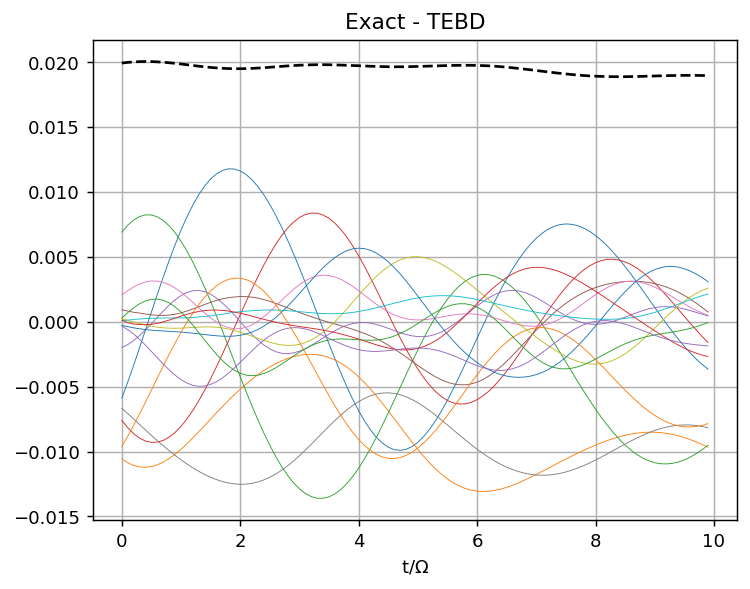

Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.025, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6778.56%/s]


Real time evolution


t=9.9, max-bond=31: 100%|###################################################################################################################################################################################################| 100/100 [00:11<00:00,  8.84it/s]

Time:11s
Max error 0.013565820092547415


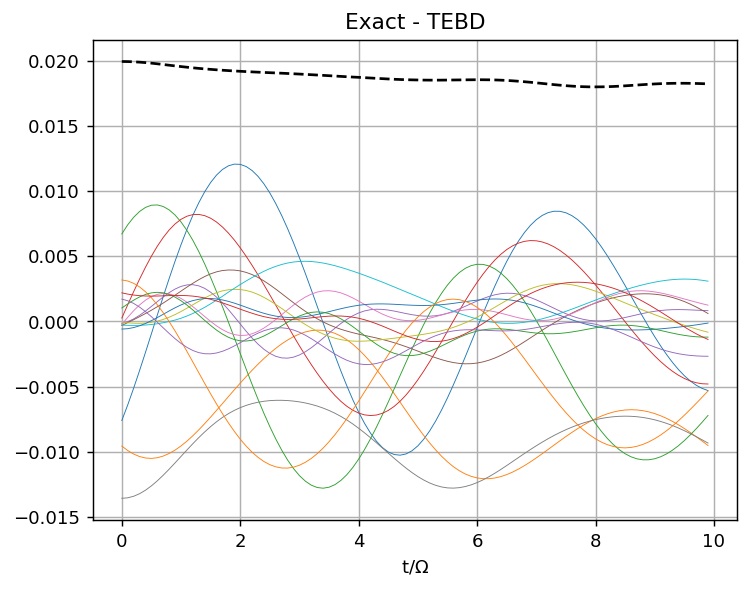

Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.025, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6979.11%/s]


Real time evolution


t=9.9, max-bond=31: 100%|###################################################################################################################################################################################################| 100/100 [00:11<00:00,  8.79it/s]

Time:11s
Max error 0.012921458300982003


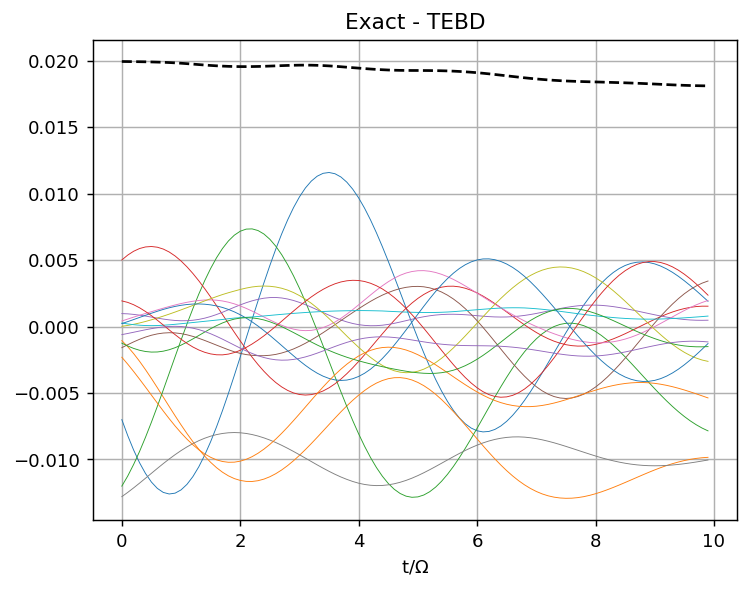

Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.025, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6749.44%/s]


Real time evolution


t=9.9, max-bond=31: 100%|###################################################################################################################################################################################################| 100/100 [00:11<00:00,  8.85it/s]

Time:11s
Max error 0.012976947697167574


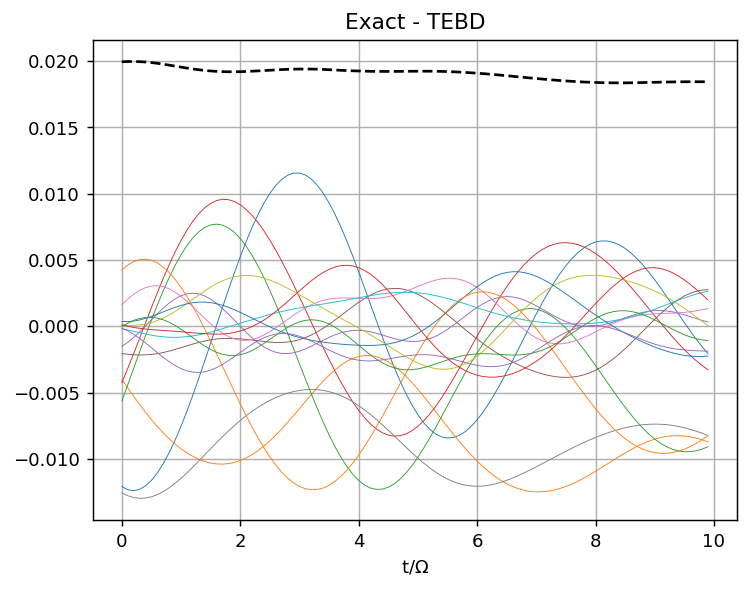

Building Hamiltonian for L=7
Initial state: random subsystem and thermal bath

done
Building Hamiltonian for L=7 

Building the spin chain 

Imaginary time evolution 



t=0.025, max-bond=4: 100%|#################################################################################################################################################################################################| 100/100 [00:00<00:00, 6910.92%/s]


Real time evolution


t=9.9, max-bond=31: 100%|###################################################################################################################################################################################################| 100/100 [00:11<00:00,  8.91it/s]

Time:11s
Max error 0.013872951991341432


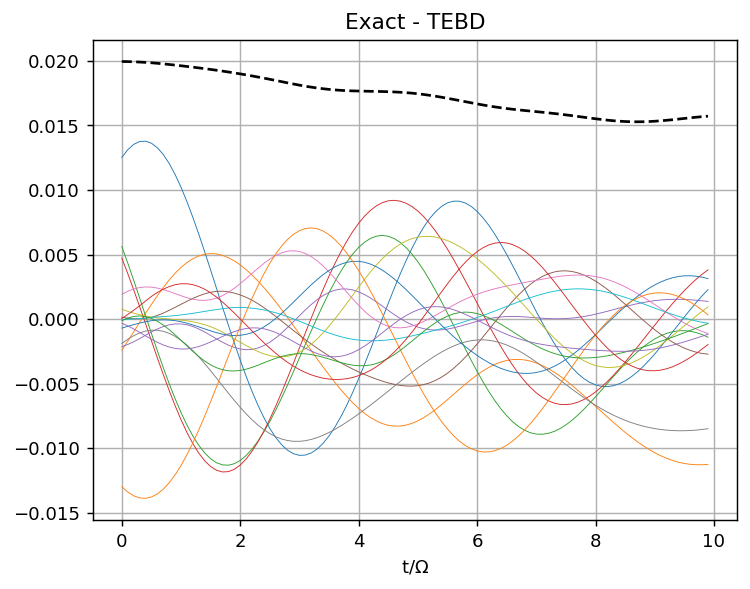

0.013387628176960514


In [18]:
avrg = 0
for k in range(5):
    #print(f'Simulation {(i*7 + j)*5 + k} / {7*7*5}')
    avrg += calculate_error(L, omega, V, V_, beta, T, dt, 10**(-5), 10**(-7), 1e-5)
print(avrg/5)

In [9]:
table

array([[0.00682243, 0.00552424, 0.00417139, 0.00419464, 0.00410984,
        0.00454527, 0.00388152],
       [0.05021028, 0.05022727, 0.02517097, 0.02550323, 0.02548311,
        0.02563907, 0.02567514],
       [0.00226081, 0.00218075, 0.00272002, 0.00269445, 0.00272258,
        0.00271166, 0.00279806],
       [0.00097657, 0.00104132, 0.00271437, 0.00265763, 0.00263804,
        0.00271124, 0.00269293],
       [0.0010118 , 0.00105415, 0.002701  , 0.00263098, 0.00266115,
        0.0026898 , 0.00265087],
       [0.00099997, 0.00095371, 0.00274505, 0.00266759, 0.00261055,
        0.00274643, 0.00263649],
       [0.00098992, 0.00096781, 0.0027409 , 0.00267565, 0.00260023,
        0.00273711, 0.00266997]])

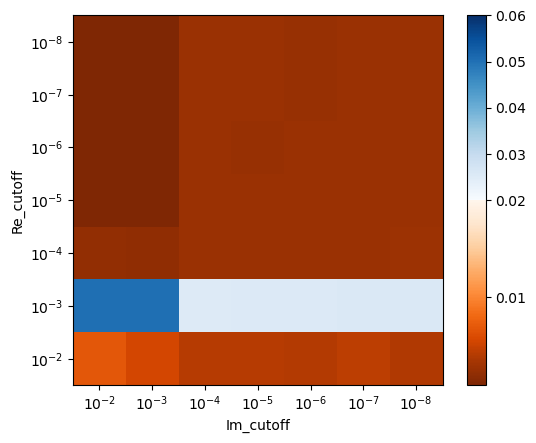

In [11]:
divnorm = mpl.colors.TwoSlopeNorm(vmin=0.001, vcenter=0.02, vmax=0.06)

top = plt.cm.get_cmap('Oranges_r', 128)
bottom = plt.cm.get_cmap('Blues', 128)
newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))
newcm = mpl.colors.ListedColormap(newcolors, name='OrangeBlue')

fig, ax = plt.subplots()

im = ax.imshow(table, origin='lower', cmap=newcm, norm=divnorm)

my_ticks = [r'$10^{-2}$', r'$10^{-3}$', r'$10^{-4}$', r'$10^{-5}$', r'$10^{-6}$', r'$10^{-7}$', r'$10^{-8}$']
ax.set_xticks([i for i in range(7)])
ax.set_xticklabels(my_ticks)
ax.set_xlabel('Im_cutoff')
ax.set_yticks([i for i in range(7)])
ax.set_yticklabels(my_ticks)
ax.set_ylabel('Re_cutoff')

fig.colorbar(im, ax=ax)

fig = plt.gcf()
#plt.legend()
plt.show()

#fig.savefig('./pictures/error_study.pdf', dpi=150)